In [1]:
!pip install PyDrive
!pip install imbalanced-learn

    100% |████████████████████████████████| 993kB 7.7MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
    100% |████████████████████████████████| 153kB 5.0MB/s 


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import warnings
from sklearn.cross_validation import train_test_split # to split the data
from scipy import stats
import IPython
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import itertools
import six
import keras
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, LSTM,BatchNormalization,Input,Concatenate,Activation,Embedding,Flatten,Add,Average,Conv1D, GlobalAveragePooling1D, MaxPooling1D,Reshape, Conv2D, MaxPooling2D,AveragePooling2D
from keras.optimizers import SGD
from keras.regularizers import l2
from keras import backend as K
from keras.layers.merge import add
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [0]:
import tensorflow as tf
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def save_variable(data,file_name):
    output = open(file_name, 'wb')
    pickle.dump(data, output)
    output.close()
    
def count_labels(data):
    df = pd.DataFrame({'data':data})
    df['data'].value_counts()
    
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3
        
def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

def build(input_shape, num_outputs, block_fn, repetitions):
    """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
    """
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    # Permute dimension order if necessary
    #if K.image_dim_ordering() == 'tf':
        #input_shape = (input_shape[1], input_shape[2], input_shape[0])

    # Load function from str if needed.
    block_fn = _get_block(block_fn)

    input = Input(shape=input_shape)
    conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

    block = pool1
    filters = 64
    for i, r in enumerate(repetitions):
        block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
        filters *= 2

        # Last activation
    block = _bn_relu(block)

    # Classifier block
    block_shape = K.int_shape(block)
    pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
    flatten1 = Flatten()(pool2)
    dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

    model = Model(inputs=input, outputs=dense)
    return model    

def scale(scaler,x):
    shape = np.shape(x)
    x = np.reshape(x, (shape[0],-1))
    x = scaler.transform(x)
    x = np.reshape(x,shape)
    return x

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
fileId = drive.CreateFile({'id': '1uIpiAFMGtKtfabSQhUSf0P1GkwGduJFh'}) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print (fileId['title'])  # folder_data.zip
fileId.GetContentFile('train3.pkl') 
fileId = drive.CreateFile({'id': '1kD7pKQni8WxIZWvG2Ig6lVaJujjYmB5T'}) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print (fileId['title'])  # folder_data.zip
fileId.GetContentFile('train.csv') 

train3.pkl
train.csv


In [0]:
#read input
music_train_data = pickle.load(open("train3.pkl","rb"))
name_csv_file = 'train.csv'
music_folder_path = 'train/train'
df = pd.read_csv(name_csv_file,header=None)
df.dropna()
train_df = df.values
mfccs = []
labels = []
for i in range(len(train_df)):
    file_name = os.path.join(music_folder_path,'%s' %(train_df[i][0]) )
    for fp in music_train_data:
        if fp["name"] == train_df[i][0]:
            mfccs.append(fp["mfccs"] )
            labels.append(train_df[i][1] - 1)        
del music_train_data

In [0]:
#padding data
for i in range(len(mfccs)):    
    if np.shape(mfccs[i])[0]!=325:
        mfccs[i] = (keras.preprocessing.sequence.pad_sequences(np.array(mfccs[i]).T,325)).T   

class_weights: {0: 1.0, 1: 0.41081150279172035, 2: 0.37352779346733567, 3: 0.45517909784262156, 4: 0.44102406064248223, 5: 0.4532835228653389, 6: 0.5206305377366581, 7: 0.23410223062338198, 8: 0.8727384113521935, 9: 0.7778181251041214} 


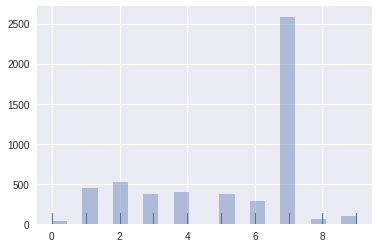

In [8]:
import math
mu =0.5
class_weights = {}
maxWeights = 0
for i in range(10):
    score = math.log(mu*len(labels)/float(len([y for y in labels if y == i])))
    class_weights[i] = score if score > 1.0 else 1.0
    maxWeights = class_weights[i] if maxWeights < class_weights[i] else maxWeights
for i in range(10):
    class_weights[i] = class_weights[i]/maxWeights
print ("class_weights: %s " %str(class_weights))
sns.distplot(labels, kde=False, rug=True);

class_weights: {0: 14.327777777777778, 1: 1.1565022421524664, 2: 0.9862332695984704, 3: 1.3978319783197832, 4: 1.3158163265306122, 5: 1.3865591397849462, 6: 1.8487455197132616, 7: 0.1994586233565352, 8: 8.319354838709678, 9: 5.546236559139785} 


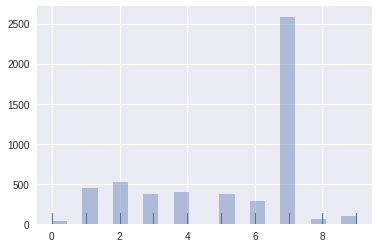

In [11]:
from sklearn.utils.class_weight import compute_class_weight
temp_class_weights = compute_class_weight('balanced', np.unique(labels), labels)
class_weights = {}
for i in range(10):
  class_weights[i] = temp_class_weights[i]
print ("class_weights: %s " %str(class_weights))
sns.distplot(labels, kde=False, rug=True);

In [0]:
from sklearn.preprocessing import MinMaxScaler
def minmaxScale(x):
    shape = np.shape(x)
    x = np.reshape(x, (shape[0],-1))
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    x = np.reshape(x,shape)
    return scaler, x


scaleMfccs, mfccs = minmaxScale(mfccs)
#save_variable(scaleMfccs,'scale.pkl')

#file_generator = drive.CreateFile({'parents':[{u'id': '1FJx_6ofTLXfz5PqwMa0h-jYm8tZvFry9'}]})
#file_generator.SetContentFile('scale.pkl')
#file_generator.Upload()

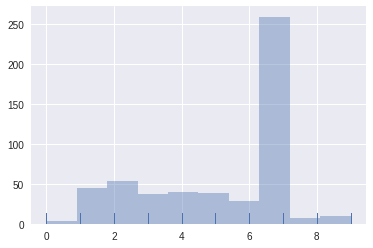

In [13]:
labels_train = []
labels_validation = []
xtr_train = []
xtr_validation = []
rate = 0.9

for i in range(10):
    
    indexes = []
    for j in range(np.shape(labels)[0]):
        if labels[j] == i:
            indexes.append(j)
    np.random.shuffle(indexes)
    idxHighTrain = int(len(indexes)*rate)
    
    labels_train.extend([labels[k] for k in indexes[:idxHighTrain]])
    xtr_train.extend([mfccs[k] for k in indexes[:idxHighTrain]])

    labels_validation.extend([labels[k] for k in indexes[idxHighTrain:]])      
    xtr_validation.extend([mfccs[k] for k in indexes[idxHighTrain:]]) 
    
sns.distplot(labels_validation, kde=False, rug=True);

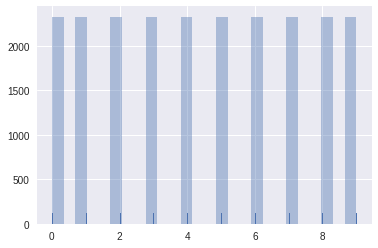

In [14]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN,SMOTETomek

#ros = RandomOverSampler(random_state=0)
ros = SMOTE(random_state=0)
#ros = SMOTE()
shape = np.shape(xtr_train)
xtr_train = np.reshape(xtr_train,(shape[0],-1))
xtr_rs_train, labels_rs_train = ros.fit_sample(xtr_train, labels_train)
sns.distplot(labels_rs_train, kde=False, rug=True);

In [0]:
xtr = mfccs
xtr_rs_train = np.reshape(np.array(xtr_rs_train),(-1,325,40))
xtr_validation = np.reshape(np.array(xtr_validation),(-1,325,40))
xtr_train = np.reshape(np.array(xtr_train),(-1,325,40))

# reshape data
xtr = np.reshape(xtr,(-1,325,40,1))
xtr_train = np.reshape(xtr_train,(-1,325,40,1))
xtr_rs_train = np.reshape(xtr_rs_train,(-1,325,40,1))
xtr_validation = np.reshape(xtr_validation,(-1,325,40,1))

In [0]:
labels_rs_train = np.reshape(labels_rs_train,(-1))
labels_train = np.reshape(labels_train,(-1))
labels_validation = np.reshape(labels_validation,(-1))
labels = np.reshape(labels,(-1))

ytr_rs_train = keras.utils.to_categorical(labels_rs_train, 10)
ytr_validation = keras.utils.to_categorical(labels_validation, 10)
ytr = keras.utils.to_categorical(labels, 10)
ytr_train = keras.utils.to_categorical(labels_train, 10)

In [17]:
print (np.shape(xtr_rs_train))
print (np.shape(ytr_rs_train))
print (np.shape(xtr_train))
print (np.shape(ytr_train))
print (np.shape(xtr_validation))
print (np.shape(ytr_validation))

(23270, 325, 40, 1)
(23270, 10)
(4637, 325, 40, 1)
(4637, 10)
(521, 325, 40, 1)
(521, 10)


In [18]:
model = build((325,40,1), 10, basic_block, [2, 2, 2, 2])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 325, 40, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 163, 20, 64)  3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 163, 20, 64)  256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 163, 20, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
from keras.callbacks import ModelCheckpoint


filepath="Zalo-resnet18.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [20]:
model.fit(xtr_rs_train , ytr_rs_train,
          validation_data= (xtr_validation, ytr_validation),
          epochs=200,batch_size=128, callbacks=callbacks_list, class_weight=class_weights)

Train on 23270 samples, validate on 521 samples
Epoch 1/200
23270/23270 [==============================] - 82s 4ms/step - loss: 1.5552 - acc: 0.7400 - f1: 0.7475 - val_loss: 2.9962 - val_acc: 0.2399 - val_f1: 0.2102

Epoch 00001: val_loss improved from inf to 2.99616, saving model to Zalo-resnet18.hdf5
Epoch 2/200
23270/23270 [==============================] - 70s 3ms/step - loss: 0.7454 - acc: 0.9051 - f1: 0.9079 - val_loss: 2.8949 - val_acc: 0.3013 - val_f1: 0.2831

Epoch 00002: val_loss improved from 2.99616 to 2.89493, saving model to Zalo-resnet18.hdf5
Epoch 3/200
23270/23270 [==============================] - 70s 3ms/step - loss: 0.5502 - acc: 0.9482 - f1: 0.9482 - val_loss: 2.9920 - val_acc: 0.2975 - val_f1: 0.2816

Epoch 00003: val_loss did not improve from 2.89493
Epoch 4/200
23270/23270 [==============================] - 71s 3ms/step - loss: 0.5802 - acc: 0.9176 - f1: 0.9169 - val_loss: 2.4030 - val_acc: 0.4395 - val_f1: 0.4047

Epoch 00004: val_loss improved from 2.89493 to 

Confusion matrix, without normalization
[[  2   0   0   1   0   0   0   1   0   0]
 [  0  17   6   0   1   1   0  20   0   0]
 [  0   1  14   0   1   1   0  35   1   0]
 [  0   0   2  31   1   0   0   3   0   0]
 [  0   0   0   0  35   0   0   5   0   0]
 [  0   0   0   0   0  33   0   5   0   0]
 [  0   0   1   0   0   0   2  25   0   0]
 [  0  12  33   3   5   1   2 203   0   0]
 [  0   0   0   2   0   0   0   2   3   0]
 [  0   1   0   0   0   0   0   8   0   1]]


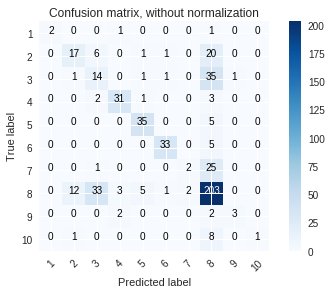

In [21]:
model_opt = load_model("Zalo-resnet18.hdf5", custom_objects={'f1': f1})
ytr_pred = model_opt.predict(xtr_validation,batch_size=128)
ytr_pred = np.argmax(ytr_pred,axis=1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels_validation,ytr_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5','6','7','8','9','10'] ,title='Confusion matrix, without normalization')


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_generator = drive.CreateFile({'parents':[{u'id': '1FJx_6ofTLXfz5PqwMa0h-jYm8tZvFry9'}]})
file_generator.SetContentFile('Zalo-resnet18.hdf5')
file_generator.Upload()

In [0]:
import os
os.listdir('./')

['sample_data', '.config']